In [174]:
#we import the libraries 
from matplotlib import pyplot
import numpy
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.image as mpimg

# Traineeship : Numerical Fluid Dynamics
## 2D Stokes flow around a square

##### Ilan Renous

In this paper, we are going to compute the low reynolds flow around a square put in a cavity where the speed on the boundaries is held constant in the x-direction $\begin{equation}\vec{u} = u \vec{e_x}\end{equation}$. This problem can be seen as a square put in the middle of a cavity where the top and bottom lid are driven in the same direction and the flow in and out the cavity is also kept at a constant. This situation is illustrated in figure 1.  

<img src="./Figures/Fig_cavity_square.png" width=300px length=300px>
#### Figure 1.  Square in a cavity with  top and bottom lid driven in the same direction and the flow in and out the cavity is kept at a constant paste.

## The Stokes Flow

The non-dimensional Navier-Stokes equation for incompressible flow is given as

\begin{equation}
Re \left(\frac{\partial u}{\partial t} + u \cdot \nabla u \right) = -\nabla p + \nabla^2 u
\end{equation}

Where $u$ and $p$ are the non-dimensional velocity and pressure, respectively.  

To obtain a Stokes flow, we assume that the Reynolds $Re$ number approaches zero.  Applying this assumption yields

\begin{equation}
\nabla p = \nabla^2 u
\end{equation}

Now, we apply the curl operator on both sides of the equation to obtain:

\begin{equation}
0 = \nabla \times - \nabla p = - \nabla \times \nabla^2 u = - \nabla^2\omega
\end{equation}

where $\nabla \times u = \omega$ is the vorticity.  

This leads us to the simplified vorticity transport equation for Stokes flow:

\begin{equation}
\nabla ^2 \omega = 0
\end{equation}

### Stream function

We define the stream function $\psi$, such that

\begin{equation}
u = \frac{\partial \psi}{\partial y} \text{   and   } v = - \frac{\partial \psi}{\partial x}
\end{equation}

where u is the x-component and v the y-component of the fluid speed. 

In 2D, we can write out the vorticity as

\begin{equation}
\omega = \frac{\partial v}{\partial x} - \frac{\partial u}{\partial y}
\end{equation}

which, combined with the previous equation yields :

\begin{equation}
\nabla^2 \psi = -\omega
\end{equation}

We have a system of two coupled equations that can describe the fluid flow in a lid-driven cavity at very low Reynolds numbers.  

\begin{equation}
\nabla^2 \omega = 0
\end{equation}

\begin{equation}
\nabla^2 \psi = -\omega
\end{equation}

The **Poisson equation** for a 2D function f with a source term b can be written as : 

$$\frac{\partial ^2 f}{\partial x^2} + \frac{\partial ^2 f}{\partial y^2} = b$$

In discretized form, this equation become:

$$\frac{f_{i+1,j}^{k}-2f_{i,j}^{k}+f_{i-1,j}^{k}}{\Delta x^2}+\frac{f_{i,j+1}^{k}-2 f_{i,j}^{k}+f_{i,j-1}^{k}}{\Delta y^2}=b_{i,j}^{k}$$

We rearrange this to obtain an equation for $f$ at point $i,j$, based on its neighbors: 

$$f_{i,j}^{k+1}=\frac{(f_{i+1,j}^{k}+f_{i-1,j}^{k})\Delta y^2+(f_{i,j+1}^{k}+f_{i,j-1}^{k})\Delta x^2-b_{i,j}^{k}\Delta x^2\Delta y^2}{2(\Delta x^2+\Delta y^2)}$$

When the term b is set to zero, we get the Laplace equation.

This is called the Jacobi method and $f_{i,j}^{k+1}$ converges towards the solution to the poisson equation.

Our system in a discret form is thus:

$$\omega_{i,j}^{k+1}=\frac{(\omega_{i+1,j}^{k}+\omega_{i-1,j}^{k})\Delta y^2+(\omega_{i,j+1}^{k}+\omega_{i,j-1}^{k})\Delta x^2}{2(\Delta x^2+\Delta y^2)}$$

$$\psi_{i,j}^{k+1}=\frac{(\psi_{i+1,j}^{k}+\psi_{i-1,j}^{k})\Delta y^2+(\psi_{i,j+1}^{k}+\psi_{i,j-1}^{k})\Delta x^2-\omega_{i,j}^{k}\Delta x^2\Delta y^2}{2(\Delta x^2+\Delta y^2)}$$

We can solve this system by evaluating $\omega_{i,j}^{k+1} $ at each iteration and us it value to evaluate $\psi_{i,j}^{k+1}$. We stop the iteration when a certain type of norm between $\psi_{i,j}^{k}$ and $\psi_{i,j}^{k+1}$ is smaller than a chosen value.

Whith $\Delta x=\Delta y$, this gives us:

In [175]:
def stokes_system(r,xi,yi,h,nx,ny,w,psi,l1_target,dx,dy,u,boundary):
    '''Performs Jacobi relaxation for the cavity flow
    
    Parameters:
    ----------
    r: float
        lentgth of the central square
    xi,yi: float
        position of the center of the central square
    dx: float
        Mesh spacing in x direction
    h: float
        heigth of the cavity
     nx, ny: 2D array of floats
        grid
    w : 2D array of floats
        Initial guess
    psi: 2D array of floats
        Initial guess
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
    l1_target: float
        Target difference between two consecutive iterates
    u: float
        speed of the undisturbed flow
    y: float
        Mesh spacing in y direction
    boundary: integer
        determine the BCS function tu use
    Returns:
    -------
    w: 2D array of float
        Distribution after relaxation      
    psi: 2D array of float
        Distribution after relaxation
    iteration: number of iteration

    ''' 
    iteration=0
    stop1=1 # we fix the norm to be one to run the loop at least once
    stop2=1
    psin = numpy.empty_like(psi)
    wn= numpy.empty_like(w)
    wk= numpy.empty_like(w)
    wk=w.copy()
    
    while(stop1>l1_target or stop2>l1_target):
        
        psin=psi.copy()
        wn=wk.copy()
        wk[1:-1,1:-1]=.25*(wn[2:,1:-1]+wn[:-2,1:-1]+wn[1:-1,:-2]+wn[1:-1,2:])
        
        psi[1:-1:,1:-1]=.25*((dx**2)*wn[1:-1,1:-1]+psin[2:,1:-1] \
                             +psin[:-2,1:-1]+psi[1:-1,:-2]+psin[1:-1,2:]) 
        
        #BCs function to use
        if boundary==1:
            psi,wk = BCs_obstacle1(wk,psi,y,xi,yi,r,h,u)
        if boundary==2:    
            psi,wk = BCs_obstacle2(wk,psi,y,xi,yi,r,h,u)  
        if boundary==3:   
            psi,wk = BCs_obstacle3(wk,psi,y,xi,yi,r,h,u)
        
        stop1=L1norm(psi,psin)
        stop2=L1norm(wk,wn)
        iteration+=1
        
        if iteration>50000: #safety break
            break
        
    return wk,psi, iteration

## Boundary conditions on the cavity

First, we are going to analyse the case without the square in the middle of the cavity. The boundaries conditions for this case are illustrated in figure 2. 

<img src="./Figures/Fig_BCS1.jpg" width=300px length=300px>
#### Figure 2.  BCs on the cavity

The boundary conditions are all specified in terms of $\psi$ and its derivatives, but the Laplace equation

$$\nabla \omega^2 = 0$$

has no $\psi$ value.  Instead, we need a way to represent the boundary conditions for $\omega$ in terms of $\psi$.  

Along the top surface of the cavity (the moving surface). 
There can't be any velocity in the $y$-direction because the surface is solid, so $\frac{\partial ^2 \psi}{\partial x^2}$ goes to zero and the equation simplifies to

\begin{equation}
\frac{\partial ^2 \psi}{\partial y^2} = -\omega
\end{equation}

A 2nd-order central difference discretization gives

\begin{equation}
\omega_j = - \left(\frac{\psi_{j+1} - 2\psi_j + \psi_{j-1}}{\Delta y^2}\right)
\end{equation}

but the value $\psi_{j+1}$ is outside of the domain. The 3rd-order discretization of $\frac{\partial \psi}{\partial y}$ evaluated along the top edge.

\begin{equation}
\left.\frac{\partial \psi}{\partial y}\right|_j = \frac{2\psi_{j+1} + 3\psi_j - 6\psi_{j-1} + \psi_{j-2}}{6 \Delta y}
\end{equation}

$\frac{\partial \psi}{\partial y}$ is a given boundary value in the problem along the top edge

\begin{equation}
\left.\frac{\partial \psi}{\partial y}\right|_j = u
\end{equation}

which leaves us with a value for $\psi_{j+1}$ that consists only of points within the domain.  

\begin{equation}
\psi_{j+1} = \frac{6\Delta y u_j - 3\psi_j + 6 \psi_{j-1} - \psi_{j-2}}{2}
\end{equation}

Plug in that result into the initial discretization from Equation and we have a boundary condition for $\omega$ along the top surface in terms of $\psi$:

\begin{equation}
\omega_{i,j} = -\frac{1}{2 \Delta y^2} (8\psi_{i, j-1}- 7\psi_{i, j} - \psi_{i, j-2}) - \frac{3u_j}{\Delta y} + \mathcal{O}(\Delta y^2)
\end{equation}

we thus get along the top surface

\begin{equation}\omega_{i,j} = -\frac{1}{2 \Delta y^2} (8\psi_{i, j-1} - 7\psi_{i, j} - \psi_{i, j-2}) - \frac{3u}{\Delta y}
\end{equation}

along the bottom surface this becomes

\begin{equation}\omega_{i,j} = -\frac{1}{2 \Delta y^2} (8\psi_{i, j+1}- 7\psi_{i, j} - \psi_{i, j+2})+ \frac{3u}{\Delta y}
\end{equation}

along the left surface

\begin{equation}\omega_{i,j} = -\frac{1}{2 \Delta y^2} (8\psi_{i+1, j}- 7\psi_{i, j} - \psi_{i+2, j})
\end{equation}

and along the right surface

\begin{equation}\omega_{i,j} = -\frac{1}{2 \Delta y^2} (8\psi_{i-1, j}- 7\psi_{i, j} - \psi_{i-2, j})
\end{equation}

In python that gives us:

In [176]:
def BCs_obstacle1(w,psi,y,xi,yi,r,h,u):
    '''BCs for a square obstacle in the middle of the grid and uniform speed u at the edge of the cavity
    
    Parameters:
    ----------
    w : 2D array of floats
        w on the Boundaries
    psi: 2D array of floats
        psi on the Boundaries
    xi: float
        middle of the x axis
    yi: float
        middle of the y axis
    r: float
        1/2 side of the cube
    h: float
        height of the cavity
    u: float
        speed of the flow on the on the edge of the cavity
    
    Returns:
    -------
    psi: 2D array of float
        Distribution after BCs
    w: 2D array of float
        Distribution after BCs
    ''' 

    #BCs cavity
        
    w[-1,:]= (-1/dx**2)*(6*dy*u-7*psi[-1,:]+8*psi[-2,:]-psi[-3,:])
    w[0,:]= (-1/dx**2)*(-6*dy*u-7*psi[0,:]+8*psi[1,:]-psi[2,:])
    w[:,0]= (-1/dx**2)*(-7*psi[:,0]+8*psi[:,1]-psi[:,2])
    w[:,-1]= (-1/dx**2)*(-7*psi[:,-1]+8*psi[:,-2]-psi[:,-3])
    return psi,w


## Implementation

We can now implement those equations. With L1 target $=10^{-6}$, the chosen norm between $\psi_{i,j}^{k}$ and $\psi_{i,j}^{k+1}$.

In [177]:
def L1norm(new, old):
    '''compute the norm between psi(k+1) and psi(k)
    
    Parameters:
    ----------
    new : 2D array of floats
        psi(k+1)
    old: 2D array of floats
        psi(k)
        
    Returns:
    -------
    norm: float
        norm between psi(k) and psi(k+1)
    ''' 
    norm = numpy.sum(numpy.abs(new-old))
    return norm


The values of the parameters of our problem are chosen as follow.

In [178]:
# resolution 
nx=51
ny=51
    
# cavity of length l and height h
l=1
h=1

# speed of the flow u
u=1

#dimension of the central square
r=int((nx-1)/10)
#position of the center of the square
xi=int((nx-1)/2)
yi=int((ny-1)/2)

#grid
x=numpy.linspace(0,l,nx)
y=numpy.linspace(0,h,ny)
#grid mesh
dx=l/(nx-1)
dy=h/(ny-1)

#norm target
l1_target = 1e-6

#potential flow
w=numpy.zeros((nx,ny))
psi=numpy.zeros((nx,ny))

$\psi$ is fixed on the edge of the cavity with the condition

\begin{equation}
\left.\frac{\partial \psi}{\partial y}\right|_j = u
\end{equation}

and 

\begin{equation}
\left.\frac{\partial \psi}{\partial x}\right|_i =0
\end{equation}

This amounts to $\psi=u y + C_1$ on the edges, $C_1$ being a constant. Because the physical value $u$ is define by the derivative of $\psi$, this constant is arboitrary and we choose it to be zero $C_1=0 $.

In [179]:
#values of psi=u*y on the cavity's boundaries
psi[:,0]=u*y[:]
psi[:,-1]=u*y[:]
psi[-1,:]=u*y[-1]
psi[0,:]=u*y[0]

We have all the parameters set up to compute the value of $\psi$ in our domain. Keeping in mind that for the moment we expect to find a uniform speed  $u$ in the $x$ direction, we should get a value of $\psi$ increasing uniformly in the $y$ direction.

number of iterations = 7254


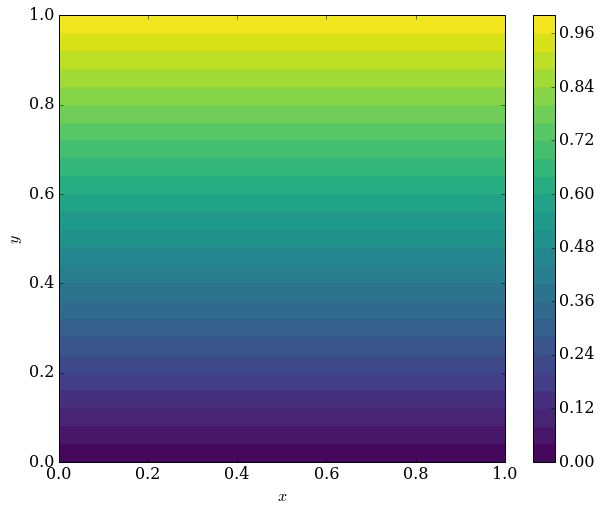

In [180]:
#we choose the first BCs function
boundary=1

#compute psi
w1,psi1,iteration = stokes_system(r,xi,yi,h,nx,ny,w,psi,l1_target,dx,dy,u,boundary)
print("number of iterations =",iteration)
#contour plot of the stream function
pyplot.figure(figsize=(10,8))
pyplot.contourf(x,y,psi,26,cmap=cm.viridis)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar();

It looks like everything worked so far!

## Boundary conditions on the central square

The BCs on the central square are illustrated in figure 2.

<img src="./Figures/Fig_BCS2.jpg" width=300px length=300px>
#### Figure 2.  BCs on the central square

We can easily conclude, from these conditions, that $\psi$ is constant on the square $\psi=C_2$. Once again it looks like this constant is arbitary and we choose it to be zero $C_2=0$ .

We express these conditions in term of $\omega$ like we did earlier.

\begin{equation}
\omega_{i,j} = -\frac{1}{2 \Delta y^2} (8\psi_{i, j-1}- 7\psi_{i, j} - \psi_{i, j-2}) - \frac{3u_j}{\Delta y} + \mathcal{O}(\Delta y^2)
\end{equation}

Since there is no flow through the cavity surface ,$\psi_{i, j}$ needs to be constant on these surfaces. This constant is chosen to be zero.

we thus get along the top surface

\begin{equation}\omega_{i,j} = -\frac{1}{2 \Delta y^2} (8\psi_{i, j-1} - 7\psi_{i, j} - \psi_{i, j-2})
\end{equation}

along the bottom surface this becomes

\begin{equation}\omega_{i,j} = -\frac{1}{2 \Delta y^2} (8\psi_{i, j+1}- 7\psi_{i, j} - \psi_{i, j+2})
\end{equation}

along the left surface

\begin{equation}\omega_{i,j} = -\frac{1}{2 \Delta y^2} (8\psi_{i+1, j}- 7\psi_{i, j} - \psi_{i+2, j})
\end{equation}

and along the right surface

\begin{equation}\omega_{i,j} = -\frac{1}{2 \Delta y^2} (8\psi_{i-1, j}- 7\psi_{i, j} - \psi_{i-2, j})
\end{equation}

With $\psi=0$ on the central square.

Adding those conditions to the BCs on the cavity, this gives us in python :

In [181]:
def BCs_obstacle2(w,psi,y,xi,yi,r,h,u):
    '''BCs for a square obstacle in the middle of the grid and uniform speed u at the edge of the cavity
    
    Parameters:
    ----------
    w : 2D array of floats
        w on the Boundaries
    psi: 2D array of floats
        psi on the Boundaries
    xi: float
        middle of the x axis
    yi: float
        middle of the y axis
    r: float
        1/2 side of the cube
    h: float
        height of the cavity
    u: float
        speed of the flow on the on the edge of the cavity
    
    Returns:
    -------
    psi: 2D array of float
        Distribution after BCs
    w: 2D array of float
        Distribution after BCs
    ''' 

    #BCs cavity
        
    w[-1,:]= (-1/dx**2)*(6*dy*u-7*psi[-1,:]+8*psi[-2,:]-psi[-3,:])
    w[0,:]= (-1/dx**2)*(-6*dy*u-7*psi[0,:]+8*psi[1,:]-psi[2,:])
    w[:,0]= (-1/dx**2)*(-7*psi[:,0]+8*psi[:,1]-psi[:,2])
    w[:,-1]= (-1/dx**2)*(-7*psi[:,-1]+8*psi[:,-2]-psi[:,-3])
    
    #BCs square
    w[yi-r,xi-r:xi+r+1]=(-1/(2*(dy)**2))*(8*psi[yi-r-1,xi-r:xi+r+1]-psi[yi-r-2,xi-r:xi+r+1])
    w[yi-r:yi+r+1,xi-r]=(-1/(2*(dy)**2))*(8*psi[yi-r:yi+r+1,xi-r-1]-psi[yi-r:yi+r+1,xi-r-2])
    w[yi+r,xi-r:xi+r+1]=(-1/(2*(dy)**2))*(8*psi[yi+r+1,xi-r:xi+r+1]-psi[yi+r+2,xi-r:xi+r+1])
    w[yi-r:yi+r+1,xi+r]=(-1/(2*(dy)**2))*(8*psi[yi-r:yi+r+1,xi+r+1]-psi[yi-r:yi+r+1,xi+r+2])
        
    return psi,w

## Computed Stream : Take 1

Let's put those condition in the stokes system solver and see what happends.

number of iterations = 2974


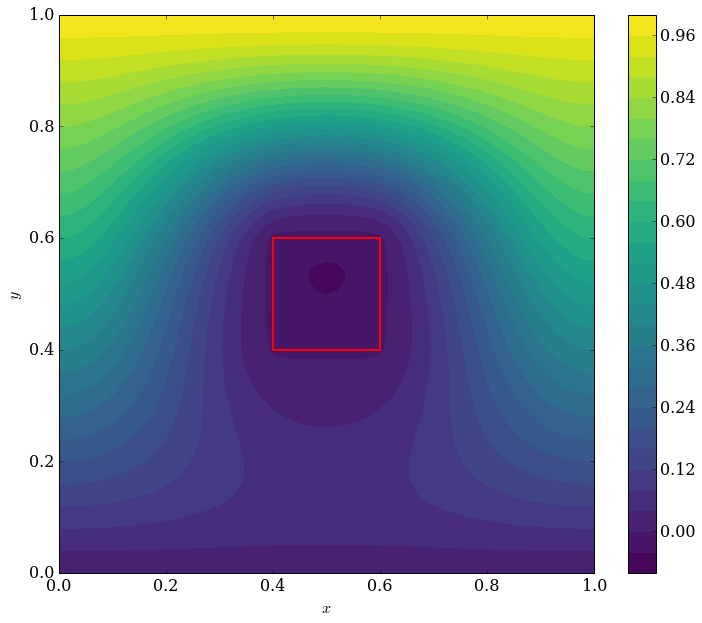

In [182]:
#we choose the second BCs function
boundary=2

#compute psi
w2,psi2,iteration = stokes_system(r,xi,yi,h,nx,ny,w,psi,l1_target,dx,dy,u,boundary)
print("number of iterations =",iteration)

#Define the central square

j=numpy.linspace(x[xi-r],x[xi+r],100)
p=numpy.linspace(y[yi-r],y[yi+r],100)
k=numpy.zeros(100)
l=numpy.zeros(100)
m=numpy.zeros(100)
n=numpy.zeros(100)
k[:]=x[xi+r]
l[:]=x[xi-r]
m[:]=y[yi+r]
n[:]=y[yi-r]

pyplot.figure(figsize=(12,10))

#plot the central square
pyplot.plot(j,m, color='r', linestyle='-', linewidth=2)
pyplot.plot(j,n, color='r', linestyle='-', linewidth=2)
pyplot.plot(k,p, color='r', linestyle='-', linewidth=2)
pyplot.plot(l,p, color='r', linestyle='-', linewidth=2)

#contour plot of psi
pyplot.contourf(x,y,psi2,26,cmap=cm.viridis)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar();

This is not really what we expected. Let's see what the stream looks likes. First we need to compute the flow speed with the definition of $\psi$

\begin{equation}
u = \frac{\partial \psi}{\partial y} \text{   and   } v = - \frac{\partial \psi}{\partial x}
\end{equation}

Implemented, this looks like:

In [183]:
def speed(psi,nx,ny,dx,dy):
    '''compute the speed from the potential
    
    Parameters:
    ----------
    psi : 2D array of floats
        potential
    nx: float
        array size x axis
    ny:float
        array size y axis
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
    
    Returns:
    -------
    ux: 2D array of float
        speed in the x direction
    vy:2D array of float
        speed in the y direction
    ''' 
    ux=numpy.zeros((nx,ny))
    vy=numpy.zeros((nx,ny))
    
    ux[:,0]=u
    ux[:,-1]=u
    ux[0,:]=u
    ux[-1,:]=u
    ux[1:-1,1:-1]=(1/(2*dy))*(psi[2:,1:-1]-psi[0:-2,1:-1])
    
    vy[:,0]=0
    vy[:,-1]=0
    vy[0,:]=0
    vy[-1,:]=0
    vy[1:-1,1:-1]=-(1/(2*dx))*(psi[1:-1,2:]-psi[1:-1,0:-2])
    
    return ux,vy

Let's plot the speed direction with a stream plot.

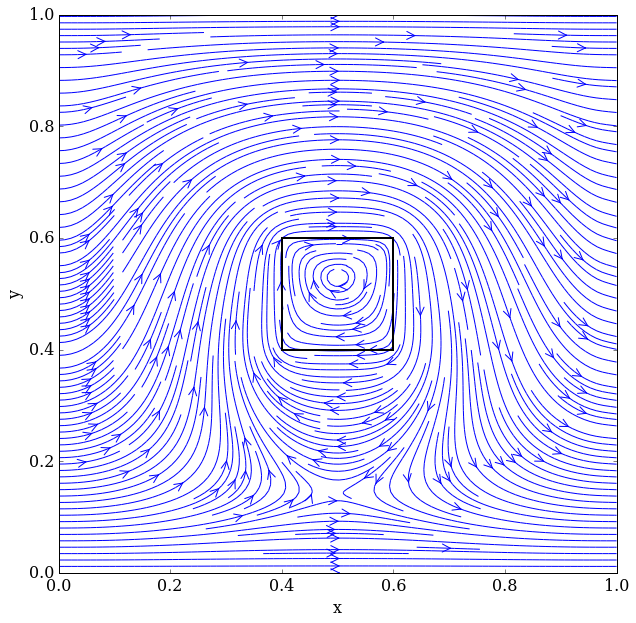

In [184]:
#compute the speed
ux2, vy2=speed(psi2,nx,ny,dx,dy)

#define a meshgrid do plot the stream
X, Y =numpy.meshgrid(x,y)
size=10
pyplot.figure(figsize=(size, (y[-1]-y[0])/(x[-1]-x[0])*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x[0],x[-1])
pyplot.ylim(y[0], y[-1])
#plot the central square
pyplot.plot(j,m, color='k', linestyle='-', linewidth=2)
pyplot.plot(j,n, color='k', linestyle='-', linewidth=2)
pyplot.plot(k,p, color='k', linestyle='-', linewidth=2)
pyplot.plot(l,p, color='k', linestyle='-', linewidth=2)
#plot of the flow speed
pyplot.streamplot(X, Y, ux2, vy2, density=3, linewidth=1, arrowsize=2, arrowstyle='->')

It looks like we added somewhere in our calculation a type of circulation force that is not in our propblem.
This problem arise from the choice of the constants for the value of $\psi$. Those are indeed arbitrary but, since we have two different set of boundary conditions, from wich two constants have to be defined, we cannot choose them as if they were not related.

## Choice of constant for $\psi$

Let's analyse our current choice of constant. For this choice of constant, the values of $\psi$ on the edge of the cavity and on the central square are illustrated on figure 3. 

<img src="./Figures/Fig_cst1.jpg" width=350px length=350px>
#### Figure 3.  Values of $\psi$ on the edges of our domain

We see that our choice of constant implies the same value for $\psi$ on the bottom edge of the central square and on the bottom edge of the cavity. Knowing that $\psi$ is constant along a streamline, we see that this choice of constant forces a line from the bottom of the cavity to the bottom of the square to be a streamline. This can be a good model for a system with a wall going from the bottom of the cavity to the bottom of the square or with a forced circulation of the speed but it is not the case we are dealing with. seeing that the constant choice implies a different physical problem, we need to find a way to choose the right relation between $C_1$ and $C_2$ that match our problem.

We are going to use the axial symmetry in respect to $y=h/2$ of our problem. This symmetry implies that the line $y=h/2$ is a streamline and thus $\psi$ is constant on this line. The value of $\psi$ on the square is then the same as the one on the cavity  at $y=h/2$. And, since the value of $\psi$ on the square is constant, we know the value of this constant. To sum up:

On the cavity $$\psi_c=uy+C_1$$

on the square $$\psi_s=C_2$$

At $y=\frac{h}{2}$ ,$$\psi_s=\psi_c$$


thus
$$u\frac{h}{2}+C_1=C_2$$

with the choice $C_1=0$, we find $C_2=u \frac{h}{2}$.

Those new BCs look like this:

<img src="./Figures/Fig_cst2.jpg" width=350px length=350px>
#### Figure 3.  Values of $\psi$ on the edges of our domain

Implemented those are:

In [185]:
def BCs_obstacle3(w,psi,y,xi,yi,r,h,u):
    '''BCs for a square obstacle in the middle of the grid and uniform speed u at the edge of the cavity
    
    Parameters:
    ----------
    w : 2D array of floats
        w on the Boundaries
    psi: 2D array of floats
        psi on the Boundaries
    xi: float
        middle of the x axis
    yi: float
        middle of the y axis
    r: float
        1/2 side of the cube
    h: float
        height of the cavity
    u: float
        speed of the flow on the on the edge of the cavity
    
    Returns:
    -------
    psi: 2D array of float
        Distribution after BCs
    w: 2D array of float
        Distribution after BCs
    ''' 

    #BCs cavity
        
    w[-1,:]= (-1/dx**2)*(6*dy*u-7*psi[-1,:]+8*psi[-2,:]-psi[-3,:])
    w[0,:]= (-1/dx**2)*(-6*dy*u-7*psi[0,:]+8*psi[1,:]-psi[2,:])
    w[:,0]= (-1/dx**2)*(-7*psi[:,0]+8*psi[:,1]-psi[:,2])
    w[:,-1]= (-1/dx**2)*(-7*psi[:,-1]+8*psi[:,-2]-psi[:,-3])
    
    #BCs square
    w[yi-r,xi-r:xi+r+1]=(-1/(2*(dy)**2))*(8*psi[yi-r-1,xi-r:xi+r+1]-7*u*(h/2)-psi[yi-r-2,xi-r:xi+r+1])
    w[yi-r:yi+r+1,xi-r]=(-1/(2*(dy)**2))*(8*psi[yi-r:yi+r+1,xi-r-1]-7*u*(h/2)-psi[yi-r:yi+r+1,xi-r-2])
    w[yi+r,xi-r:xi+r+1]=(-1/(2*(dy)**2))*(8*psi[yi+r+1,xi-r:xi+r+1]-7*u*(h/2)-psi[yi+r+2,xi-r:xi+r+1])
    w[yi-r:yi+r+1,xi+r]=(-1/(2*(dy)**2))*(8*psi[yi-r:yi+r+1,xi+r+1]-7*u*(h/2)-psi[yi-r:yi+r+1,xi+r+2])
        
    return psi,w

We can now compute those conditions and see what the stream looks like.

## Computed Stream : take 2

In [187]:
#we choose the third BCs function
boundary=3

#compute psi
w3,psi3,iteration = stokes_system(r,xi,yi,h,nx,ny,w,psi,l1_target,dx,dy,u,boundary)
print("number of iterations =",iteration)

number of iterations = 2978


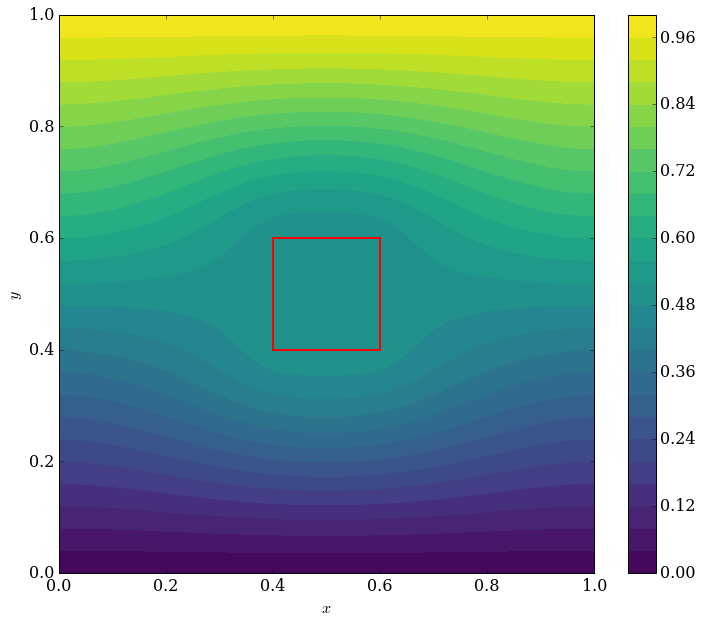

In [188]:
pyplot.figure(figsize=(12,10))
pyplot.plot(j,m, color='r', linestyle='-', linewidth=2)
pyplot.plot(j,n, color='r', linestyle='-', linewidth=2)
pyplot.plot(k,p, color='r', linestyle='-', linewidth=2)
pyplot.plot(l,p, color='r', linestyle='-', linewidth=2)
pyplot.contourf(x,y,psi3,26,cmap=cm.viridis)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar();

It does indeed looks more like what we could expect for the flow without any circulation. It is very clear in this picture that $\psi$ is constant at $y=\frac{h}{2}$.

Let's plot the stream.

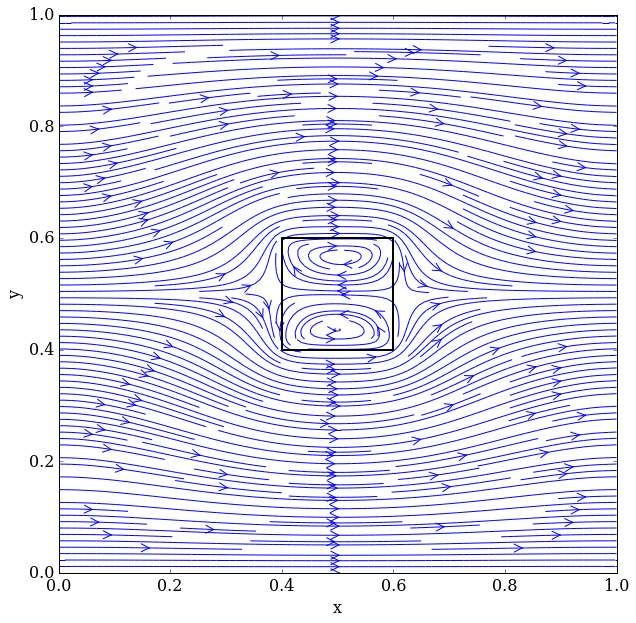

In [189]:
#compute the speed
ux3, vy3=speed(psi3,nx,ny,dx,dy)

#usual plot
size=10
pyplot.figure(figsize=(size, (y[-1]-y[0])/(x[-1]-x[0])*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x[0],x[-1])
pyplot.ylim(y[0], y[-1])
pyplot.plot(j,m, color='k', linestyle='-', linewidth=2)
pyplot.plot(j,n, color='k', linestyle='-', linewidth=2)
pyplot.plot(k,p, color='k', linestyle='-', linewidth=2)
pyplot.plot(l,p, color='k', linestyle='-', linewidth=2)
pyplot.streamplot(X, Y, ux3, vy3, density=3, linewidth=1, arrowsize=2, arrowstyle='->')

It looks really nice but the flow inside the square is a bit strange. Theyre shouldn't, of course, be any flow in the square. This plot gives the direction of the stream but no information on the norm of the speed. We can draw a contour plot the norm of speed to see if it is really significant inside the square. Using the relation $$s= \sqrt{u^2+v^2}$$ where $s$ is the norm of the speed, we find:

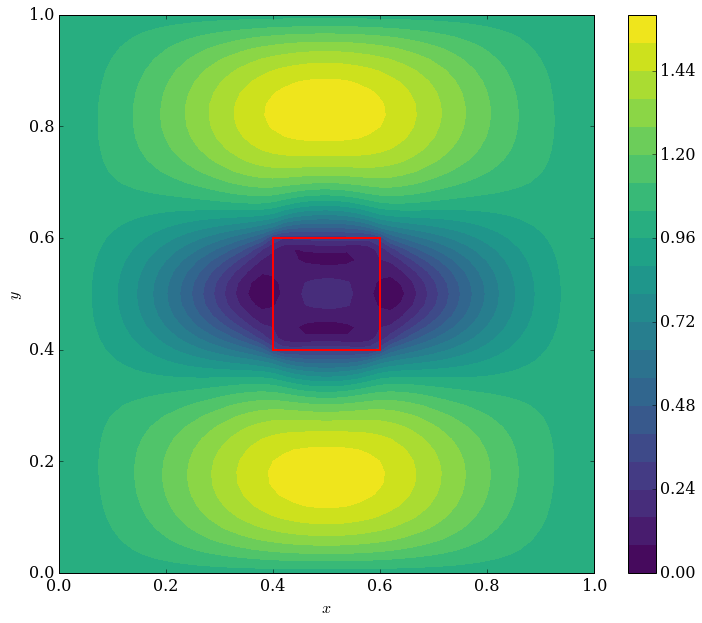

In [202]:
#compute the speed norm
s=numpy.zeros((nx,ny))
s[:,:]=numpy.sqrt(((ux3[:,:])**2+(vy3[:,:])**2))

#usual plot
pyplot.figure(figsize=(12,10))
pyplot.plot(j,m, color='r', linestyle='-', linewidth=2)
pyplot.plot(j,n, color='r', linestyle='-', linewidth=2)
pyplot.plot(k,p, color='r', linestyle='-', linewidth=2)
pyplot.plot(l,p, color='r', linestyle='-', linewidth=2)

#contour plot of the norm of the speed
pyplot.contourf(x,y,s,20,cmap=cm.viridis)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.colorbar();

We can clearly see that the speed inside the square is really close to zero. This slight difference might be due to numerical erros.

## A More General Approach Than The Choice of Constant

The choice of constant we made was based on the symmetry of this problem. If we chose not to put the square on the center off the cavity, the result of our code would not be the physical result. There is nonetheless a general condition on $\omega$ that fixes its value on the boundary. Let's find out what this condition is.

First we look at result the curl of the curl operator on the speed $\vec{u}$

\begin{equation}
\vec{\nabla} \times\vec{\nabla} \times\vec{u} =-\nabla^2\ \vec{u} +\vec{\nabla} (\vec{\nabla}  \vec{u})
\end{equation}

Because the flow is considered incompressible , we have

\begin{equation}
\vec{\nabla}  \vec{u}=0
\end{equation}


From the equation 

\begin{equation}
\vec{\nabla} p = \nabla^2 \vec{u}
\end{equation}

we see that 

\begin{equation}
\vec{\nabla} \times\vec{\nabla} \times\vec{u} =\vec{\nabla} p 
\end{equation}

We will now take the integral the on contour $\mathcal{C}$ of the square of both side of this equation

\begin{equation}
\int_{\mathcal{C}} (\vec{\nabla} \times\vec{\omega})\cdot\vec{dl} =\int_{\mathcal{C}}(\vec{\nabla} p) \cdot \vec{dl}
\end{equation}

Where $\vec{dl}=dx\vec{1_x}+dy\vec{1_y}$ is a small vector element on the curve $\mathcal{C}$ . The right hand side of the equation is of course zero since $p$ is a physical value and is thus single-valued. Since $\vec{\omega}=\omega\vec{1_z}$, we finaly have

\begin{equation}
\int_{\mathcal{C}} (\vec{\nabla} {\omega})\cdot\vec{dk} =0
\end{equation}

Where $\vec{dk}=-dy\vec{1_x}+dx\vec{1_y}$.

We can now implement this condition to see that it is satisfied whith the second choice of constant but not wih the first one.

In [192]:
def cont(fx,fy,dx,dy,yi,xi,r):
    '''compute the value of the integral given above
    
    Parameters:
    ----------
    fx : 2D array of floats
        x-component
    fy : 2D array of floats
        y-component
    xi: float
        middle of the x axis
    yi: float
        middle of the y axis
    r: float
        1/2 side of the cube
    Returns:
    -------
    cont: float
        value of the integral

    ''' 

    
    fu=numpy.zeros((2*r+1))
    fd=numpy.zeros((2*r+1))
    fr=numpy.zeros((2*r+1))
    fl=numpy.zeros((2*r+1))
    fu[:]=fy[yi+r,xi-r:xi+r+1]
    fd[:]=fy[yi-r,xi-r:xi+r+1]
    fr[:]=fx[yi-r:yi+r+1,xi+r]
    fl[:]=fx[yi-r:yi+r+1,xi-r]
    cont=numpy.sum(-dy*(fu-fd)+dx*(fr-fl))
    
    return cont

In [191]:
def grad(w,dx,dy,nx,ny):
        '''compute the gradient of a function w
    
    Parameters:
    ----------
    w : 2D array of floats
        w on the Boundaries
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
    nx: float
        array size x axis
    ny:float
        array size y axis
    Returns:
    -------
    dw_x: 2D array of float
        x-component of the gradient
    dw_y: 2D array of float
        y-component of the gradient
    ''' 
    dw_x=numpy.zeros((nx,ny))
    dw_y=numpy.zeros((nx,ny))
    dw_x[1:-1,1:-1]=(w[1:-1,2:]-w[1:-1,:-2])/(2*dx)
    dw_y[1:-1,1:-1]=(w[2:,1:-1]-w[:-2,1:-1])/(2*dy)
    return dw_x, dw_y

In [194]:
#compute the integral with w3, the potential with the right choice of constant
dw_x3, dw_y3 = grad(w3,dx,dy,nx,ny,xi,yi,r) 
contw3=cont(dw_x3,dw_y3,dx,dy,yi,xi,r)
print("integral with the first choice of constant=",contw3)

integral with the first choice of constant= 2.62012633812e-14


In [196]:
#compute the integral with w2, the potential with the right choice of constant
dw_x2, dw_y2 = grad(w2,dx,dy,nx,ny,xi,yi,r) 
contw2=cont(dw_x2,dw_y2,dx,dy,yi,xi,r)
print("integral with the second choice of constant=",contw2)

integral with the second choice of constant= -1.64313007645e-14


We could minimize the value of this integral at each iteration of the stokes system solver to be able to solve this problem without the help of symmetry. But this is out of the scope of this report.

## Pressure and Force

From the equations above, we have

\begin{equation}
\vec{\nabla} p = \nabla^2 \vec{u}
\end{equation}

We can evaluate the forces in our system by

\begin{equation}
\vec{F}=-\vec{\nabla} p
\end{equation}

This let us with:
$$Fx_{i,j}=-\frac{ux_{i+1,j}-2ux_{i,j}+ux_{i-1,j}}{\Delta x^2}-\frac{ux_{i,j+1}-2 ux_{i,j}+ux_{i,j-1}}{\Delta y^2}$$

$$Fy_{i,j}=-\frac{uy_{i+1,j}-2uy_{i,j}+uy_{i-1,j}}{\Delta x^2}-\frac{uy_{i,j+1}-2 uy_{i,j}+uy_{i,j-1}}{\Delta y^2}$$

Where Fx and Fy are the x and y component of the force respectively and ux and uy the x and y component of the speed. We compute those equations.

In [197]:
def Force (ux,uy,nx,ny,dx,dy):
    '''compute the force from the speed
    Parameters:
    ----------
    ux : 2D array of floats
        speed in the x-direction
    uy : 2D array of floats
        speed in the y-direction    
    nx: float
        array size x axis
    ny:float
        array size y axis
    dx: float
        Mesh spacing in x direction
    dy: float
        Mesh spacing in y direction
    Returns:
    -------
    Fx: 2D array of float
        force in the x direction
    Fy:2D array of float
        force in the y direction
    '''
    Fx=numpy.zeros((nx,ny))
    Fy=numpy.zeros((nx,ny))
    Fx[1:-1,1:-1]=-(1/(dx**2))*(ux[1:-1,2:]-2*ux[1:-1,1:-1]+ux[1:-1,:-2])-(1/(dy**2))*(ux[2:,1:-1]-2*ux[1:-1,1:-1]+ux[:-2,1:-1])
    Fy[1:-1,1:-1]=-(1/(dx**2))*(uy[1:-1,2:]-2*uy[1:-1,1:-1]+uy[1:-1,:-2])-(1/(dy**2))*(uy[2:,1:-1]-2*uy[1:-1,1:-1]+uy[:-2,1:-1])
    return Fx,Fy

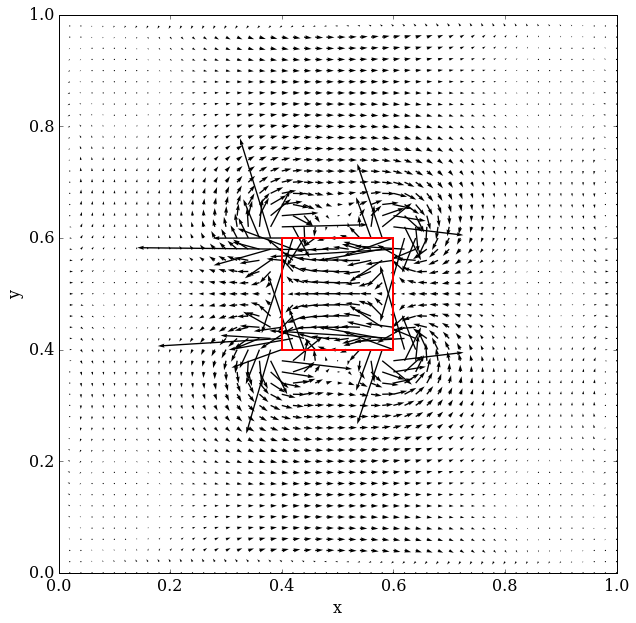

In [198]:
Fx3,Fy3 = Force (ux3,vy3,nx,ny,dx,dy)
size=10
pyplot.figure(figsize=(size, (y[-1]-y[0])/(x[-1]-x[0])*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x[0],x[-1])
pyplot.ylim(y[0], y[-1])
pyplot.plot(j,m, color='r', linestyle='-', linewidth=2)
pyplot.plot(j,n, color='r', linestyle='-', linewidth=2)
pyplot.plot(k,p, color='r', linestyle='-', linewidth=2)
pyplot.plot(l,p, color='r', linestyle='-', linewidth=2)
pyplot.quiver(x,y,Fx3,Fy3)

In [199]:

contF3=cont(Fx3,Fy3,dx,dy,yi,xi,r)

Fx2,Fy2 = Force (ux2,vy2,nx,ny,dx,dy)
contF2=cont(Fx2,Fy2,dx,dy,yi,xi,r)

print(contF2)
print(contF3)

6.64403248769
6.6440324871


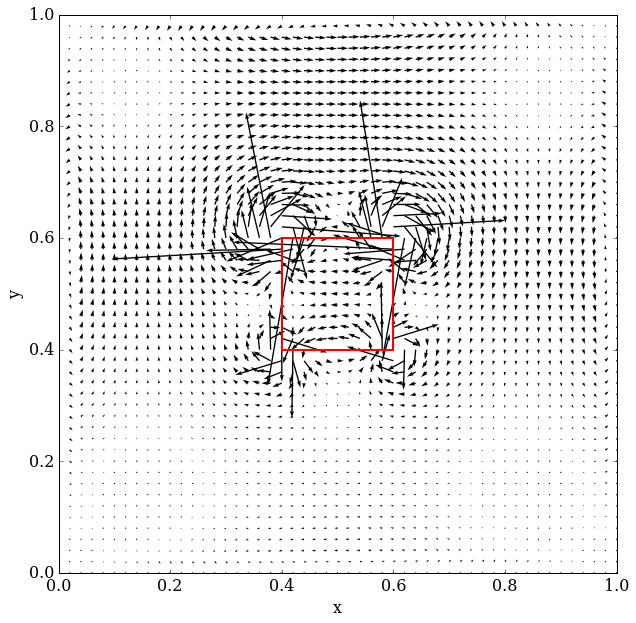

In [200]:
Fx2,Fy2 = Force (ux2,vy2,nx,ny,dx,dy)
size=10
pyplot.figure(figsize=(size, (y[-1]-y[0])/(x[-1]-x[0])*size))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.xlim(x[0],x[-1])
pyplot.ylim(y[0], y[-1])
pyplot.plot(j,m, color='r', linestyle='-', linewidth=2)
pyplot.plot(j,n, color='r', linestyle='-', linewidth=2)
pyplot.plot(k,p, color='r', linestyle='-', linewidth=2)
pyplot.plot(l,p, color='r', linestyle='-', linewidth=2)
pyplot.quiver(x,y,Fx2,Fy2)

##### Source

(1) We used the following lectures https://github.com/numerical-mooc/numerical-mooc available under Creative Commons Attribution license CC-BY 4.0, (c)2014 L.A. Barba, C. Cooper, G.F. Forsyth, A. Krishnan.

In [203]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../../styles/numericalmoocstyle.css'
HTML(open(css_file, "r").read())